# Unsteady Flow Operations

## Overview

This notebook demonstrates reading and manipulating **unsteady flow files** (`.u##` format). These define time-varying boundary conditions and simulation parameters.

### What You'll Learn
- Parse unsteady flow file structure
- Extract boundary condition time series
- Modify initial condition lines
- Update simulation parameters

### LLM Forward Approach
- **Verification**: Compare to HEC-RAS GUI
- **Audit Trail**: Save modified flow files
- **Reproducibility**: Document parameter changes

### Reference Documentation
- [HEC-RAS User's Manual, Chapter 7: Entering Flow Data](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx)
- [HEC-RAS Hydraulic Reference Manual](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx)

In [1]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = False  # <-- TOGGLE THIS

if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"📁 LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("📦 PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander
from ras_commander import HdfResultsXsec, RasCmdr, RasExamples, RasPlan, RasUnsteady, init_ras_project, ras

# Additional imports
import os
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

# Verify which version loaded
import ras_commander
print(f"✓ Loaded: {ras_commander.__file__}")

# Set to True to generate plots, False to skip plotting
generate_plots = True

📦 PIP PACKAGE MODE: Loading installed ras-commander


✓ Loaded: c:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\ras_commander\__init__.py


## Parameters

Configure these values to customize the notebook for your project.

In [ ]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# Project Configuration
PROJECT_NAME = "Muncie"           # Example project to extract
RAS_VERSION = "6.6"               # HEC-RAS version (6.3, 6.5, 6.6, etc.)

# Execution Settings
PLAN = "01"                       # Plan number to execute
NUM_CORES = 4                     # CPU cores for 2D computation
RUN_SUFFIX = "run"                # Suffix for run folder (e.g., Muncie_run)


In [2]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

# Set to True to generate plots, False to skip plotting
generate_plots = True

## Understanding Unsteady Flow Files in HEC-RAS

Unsteady flow files (`.u*` files) in HEC-RAS define the time-varying boundary conditions that drive dynamic simulations. These include:

- **Flow Hydrographs**: Time-series of flow values at model boundaries
- **Stage Hydrographs**: Time-series of water surface elevations
- **Lateral Inflows**: Distributed inflows along a reach
- **Gate Operations**: Time-series of gate settings
- **Meteorological Data**: Rainfall, evaporation, and other meteorological inputs

The `RasUnsteady` class in RAS Commander provides methods for working with these files, including extracting boundaries, reading tables, and modifying parameters.

Let's set up our working directory and define paths to example projects:

## Downloading and Extracting Example HEC-RAS Projects

We'll use the `RasExamples` class to download and extract an example HEC-RAS project with unsteady flow files. For this notebook, we'll use the "Balde Eagle Creek" project.

In [3]:
# Extract the Bald Eagle Creek example project
# The extract_project method downloads the project from GitHub if not already present,
# and extracts it to the example_projects folder
bald_eagle_path = RasExamples.extract_project(PROJECT_NAME, suffix="300")
print(f"Extracted project to: {bald_eagle_path}")  


# Verify the path exists
print(f"Bald Eagle Creek project exists: {bald_eagle_path.exists()}")

2025-12-15 12:24:28 - ras_commander.RasExamples - INFO - Found zip file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\Example_Projects_6_6.zip


2025-12-15 12:24:28 - ras_commander.RasExamples - INFO - Loading project data from CSV...


2025-12-15 12:24:28 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.


2025-12-15 12:24:28 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----


2025-12-15 12:24:28 - ras_commander.RasExamples - INFO - Extracting project 'Balde Eagle Creek'


2025-12-15 12:24:28 - ras_commander.RasExamples - INFO - Folder 'Balde Eagle Creek' already exists. Deleting existing folder...


2025-12-15 12:24:28 - ras_commander.RasExamples - INFO - Existing folder 'Balde Eagle Creek' has been deleted.


2025-12-15 12:24:28 - ras_commander.RasExamples - INFO - Successfully extracted project 'Balde Eagle Creek' to C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek


Extracted project to: C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek
Bald Eagle Creek project exists: True


## Step 1: Project Initialization

The first step is to initialize the HEC-RAS project. This is done using the `init_ras_project()` function, which takes the following parameters:

- `ras_project_folder`: Path to the HEC-RAS project folder (required)
- `ras_version`: HEC-RAS version (e.g., "6.6") or path to Ras.exe (required first time)

This function initializes the global `ras` object that we'll use for the rest of the notebook.

In [4]:
# Initialize the HEC-RAS project
# This function returns a RAS object, but also updates the global 'ras' object
# Parameters:
#   - ras_project_folder: Path to the HEC-RAS project folder
#   - ras_version: HEC-RAS version or path to Ras.exe

init_ras_project(bald_eagle_path, RAS_VERSION)
print(f"Initialized HEC-RAS project: {ras.project_name}")

# Display the unsteady flow files in the project


2025-12-15 12:24:28 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.rasmap


Initialized HEC-RAS project: BaldEagle


In [5]:
print("\nHEC-RAS Project Plan Data (plan_df):")
ras.plan_df


HEC-RAS Project Plan Data (plan_df):


,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,PS Cores,DSS File,Friction Slope Method,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path,flow_type
0,01,02,01,Unsteady with Bridges and Dam,5.00,UnsteadyFlow,"18FEB1999,0000,24FEB1999,0500",2MIN,1HOUR,1,...,None,dss,2,None,01,C:\GH\ras-commander\examples\example_projects_...,02,C:\GH\ras-commander\examples\example_projects_...,C:\GH\ras-commander\examples\example_projects_...,Unsteady
1,02,None,01,Steady Flow Run,NaN,SteadyRun,"02/18/1999,0000,02/24/1999,0500",2MIN,NaN,1,...,None,dss,1,None,01,C:\GH\ras-commander\examples\example_projects_...,02,C:\GH\ras-commander\examples\example_projects_...,C:\GH\ras-commander\examples\example_projects_...,Steady


In [6]:
print("\nHEC-RAS Project Geometry Data (geom_df):")
ras.geom_df


HEC-RAS Project Geometry Data (geom_df):


,geom_file,geom_number,full_path,hdf_path
0,g01,01,C:\GH\ras-commander\examples\example_projects_...,C:\GH\ras-commander\examples\example_projects_...


In [7]:
print("\nHEC-RAS Project Unsteady Flow Data (unsteady_df):")

ras.unsteady_df


HEC-RAS Project Unsteady Flow Data (unsteady_df):


,unsteady_number,full_path,Flow Title,Program Version,Use Restart,Precipitation Mode,Wind Mode,Met BC=Precipitation|Mode,Met BC=Evapotranspiration|Mode,Met BC=Precipitation|Expanded View,Met BC=Precipitation|Constant Units,Met BC=Precipitation|Gridded Source
0,02,C:\GH\ras-commander\examples\example_projects_...,Flow Hydrograph 2,6.30,0,Disable,No Wind Forces,None,None,0,mm/hr,DSS


In [8]:
print("\nHEC-RAS Project Boundary Data (boundaries_df):")
print("Columns:", list(ras.boundaries_df.columns))
ras.boundaries_df


HEC-RAS Project Boundary Data (boundaries_df):
Columns: ['unsteady_number', 'boundary_condition_number', 'river_reach_name', 'river_station', 'storage_area_name', 'pump_station_name', 'bc_type', 'hydrograph_type', 'Interval', 'DSS Path', 'Use DSS', 'Use Fixed Start Time', 'Fixed Start Date/Time', 'Is Critical Boundary', 'Critical Boundary Flow', 'hydrograph_num_values', 'hydrograph_values', 'full_path', 'Flow Title', 'Program Version', 'Use Restart', 'Precipitation Mode', 'Wind Mode', 'Met BC=Precipitation|Mode', 'Met BC=Evapotranspiration|Mode', 'Met BC=Precipitation|Expanded View', 'Met BC=Precipitation|Constant Units', 'Met BC=Precipitation|Gridded Source']


,unsteady_number,boundary_condition_number,river_reach_name,river_station,storage_area_name,pump_station_name,bc_type,hydrograph_type,Interval,DSS Path,...,Flow Title,Program Version,Use Restart,Precipitation Mode,Wind Mode,Met BC=Precipitation|Mode,Met BC=Evapotranspiration|Mode,Met BC=Precipitation|Expanded View,Met BC=Precipitation|Constant Units,Met BC=Precipitation|Gridded Source
0,02,1,Bald Eagle,Loc Hav,138154.4,,Flow Hydrograph,Flow Hydrograph,1HOUR,,...,Flow Hydrograph 2,6.30,0,Disable,No Wind Forces,None,None,0,mm/hr,DSS
1,02,2,Bald Eagle,Loc Hav,81500,,Gate Opening,None,NaN,NaN,...,Flow Hydrograph 2,6.30,0,Disable,No Wind Forces,None,None,0,mm/hr,DSS
2,02,3,Bald Eagle,Loc Hav,659.942,,Rating Curve,None,NaN,,...,Flow Hydrograph 2,6.30,0,Disable,No Wind Forces,None,None,0,mm/hr,DSS


## Understanding the RasUnsteady Class

The `RasUnsteady` class provides functionality for working with HEC-RAS unsteady flow files (`.u*` files). Key operations include:

1. **Extracting Boundary Conditions**: Read and parse boundary conditions from unsteady flow files
2. **Modifying Flow Titles**: Update descriptive titles for unsteady flow scenarios
3. **Managing Restart Settings**: Configure restart file options for continuing simulations
4. **Working with Tables**: Extract, modify, and update flow tables

Most methods in this class are static and work with the global `ras` object by default, though you can also pass in a custom RAS object.

## Step 2: Extract Boundary Conditions and Tables

The `extract_boundary_and_tables()` method from the `RasUnsteady` class allows us to extract boundary conditions and their associated tables from an unsteady flow file.

Parameters for `RasUnsteady.extract_boundary_and_tables()`:
- `unsteady_file` (str): Path to the unsteady flow file
- `ras_object` (optional): Custom RAS object to use instead of the global one

Returns:
- `pd.DataFrame`: DataFrame containing boundary conditions and their associated tables

Let's see how this works with our example project:

In [9]:
# Get the path to unsteady flow file "02"
unsteady_file = RasPlan.get_unsteady_path("02")
print(f"Unsteady flow file path: {unsteady_file}")

# Extract boundary conditions and tables
boundaries_df = RasUnsteady.extract_boundary_and_tables(unsteady_file)
print(f"Extracted {len(boundaries_df)} boundary conditions from the unsteady flow file.")


2025-12-15 12:24:28 - ras_commander.RasUnsteady - INFO - Successfully extracted boundaries and tables from C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.u02


Unsteady flow file path: C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.u02
Extracted 3 boundary conditions from the unsteady flow file.


## Step 3: Print Boundaries and Tables

The `print_boundaries_and_tables()` method provides a formatted display of the boundary conditions and their associated tables. This method doesn't return anything; it just prints the information in a readable format.

Parameters for `RasUnsteady.print_boundaries_and_tables()`:
- `boundaries_df` (pd.DataFrame): DataFrame containing boundary conditions from `extract_boundary_and_tables()`

Let's use this method to get a better understanding of our boundary conditions:

In [10]:
# Print the boundaries and tables in a formatted way
print("Detailed boundary conditions and tables:")
RasUnsteady.print_boundaries_and_tables(boundaries_df)

Detailed boundary conditions and tables:

Boundaries and Tablesin boundaries_df:

Boundary 1:
River Name: Bald Eagle
Reach Name: Loc Hav
River Station: 138154.4
DSS File: 

Tables for this boundary:

Flow Hydrograph:
         Value
0     1075.530
1     1301.640
2     1676.940
3     2199.120
4     2864.950
5     3670.340
6     4610.320
7     5679.080
8     6870.050
9     8175.880
10    9588.521
11    1099.261
12    2698.791
13    4377.231
14    6124.261
15    7929.081
16    9780.592
17    1667.362
18    3577.750
19   25500.000
20   27422.250
21   29332.640
22   31219.410
23   33070.920
24   34875.740
25   36622.770
26   38301.210
27   39900.740
28   41411.480
29   42824.120
30   44129.950
31   45320.920
32   46389.680
33   47329.660
34   48135.050
35   48800.880
36   49323.060
37   49698.360
38   49924.480
39   50000.000
40   49924.480
41   49698.360
42   49323.060
43   48800.880
44   48135.050
45   47329.660
46   46389.680
47   45320.920
48   44129.950
49   42824.120
50   41411.480
51 

## Understanding Boundary Condition Types

The output above shows the different types of boundary conditions in our unsteady flow file. Let's understand what each type means:

1. **Flow Hydrograph**: A time series of flow values (typically in cfs or cms) entering the model at a specific location. These are used at upstream boundaries or internal points where flow enters the system.

2. **Stage Hydrograph**: A time series of water surface elevations (typically in ft or m) that define the downstream boundary condition.

3. **Gate Openings**: Time series of gate settings (typically height in ft or m) for hydraulic structures such as spillways, sluice gates, or other control structures.

4. **Lateral Inflow Hydrograph**: Flow entering the system along a reach, not at a specific point. This can represent tributary inflows, overland flow, or other distributed inputs.

5. **Normal Depth**: A boundary condition where the water surface slope is assumed to equal the bed slope. This is represented by a friction slope value.

Let's look at a specific boundary condition in more detail:

In [11]:
# Let's examine the first boundary condition in more detail
if not boundaries_df.empty:
    first_boundary = boundaries_df.iloc[0]
    print(f"Detailed look at boundary condition {1}:")
    
    # Print boundary location components
    print(f"\nBoundary Location:")
    print(f"  River Name: {first_boundary.get('River Name', 'N/A')}")
    print(f"  Reach Name: {first_boundary.get('Reach Name', 'N/A')}")
    print(f"  River Station: {first_boundary.get('River Station', 'N/A')}")
    print(f"  Storage Area Name: {first_boundary.get('Storage Area Name', 'N/A')}")
    
    # Print boundary condition type and other properties
    print(f"\nBoundary Properties:")
    print(f"  Boundary Type: {first_boundary.get('bc_type', 'N/A')}")
    print(f"  DSS File: {first_boundary.get('DSS File', 'N/A')}")
    print(f"  Use DSS: {first_boundary.get('Use DSS', 'N/A')}")
    
    # Print table statistics if available
    if 'Tables' in first_boundary and isinstance(first_boundary['Tables'], dict):
        print(f"\nTable Information:")
        for table_name, table_df in first_boundary['Tables'].items():
            print(f"  {table_name}: {len(table_df)} values")
            if not table_df.empty:
                print(f"    Min Value: {table_df['Value'].min()}")
                print(f"    Max Value: {table_df['Value'].max()}")
                print(f"    First 5 Values: {table_df['Value'].head(5).tolist()}")
else:
    print("No boundary conditions found in the unsteady flow file.")

Detailed look at boundary condition 1:

Boundary Location:
  River Name: Bald Eagle
  Reach Name: Loc Hav
  River Station: 138154.4
  Storage Area Name: 

Boundary Properties:
  Boundary Type: N/A
  DSS File: 
  Use DSS: N/A

Table Information:
  Flow Hydrograph: 163 values
    Min Value: 1.0
    Max Value: 50000.0
    First 5 Values: [1075.53, 1301.64, 1676.94, 2199.12, 2864.95]


## Step 4: Update Flow Title

The flow title in an unsteady flow file provides a description of the simulation scenario. The `update_flow_title()` method allows us to modify this title.

Parameters for `RasUnsteady.update_flow_title()`:
- `unsteady_file` (str): Full path to the unsteady flow file
- `new_title` (str): New flow title (max 24 characters)
- `ras_object` (optional): Custom RAS object to use instead of the global one

Let's clone an unsteady flow file and update its title:

In [12]:
# Clone unsteady flow "02" to create a new unsteady flow file
new_unsteady_number = RasPlan.clone_unsteady("02")
print(f"New unsteady flow created: {new_unsteady_number}")

2025-12-15 12:24:28 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.u02 to C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.u01


2025-12-15 12:24:28 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.u01


2025-12-15 12:24:28 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 01


2025-12-15 12:24:28 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.rasmap


New unsteady flow created: 01


In [13]:
new_unsteady_number

'01'

In [14]:
# Get the path to the new unsteady flow file
new_unsteady_file = RasPlan.get_unsteady_path(new_unsteady_number)
print(f"New unsteady flow file path: {new_unsteady_file}")

New unsteady flow file path: C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.u01


In [15]:
new_unsteady_file

'C:\\GH\\ras-commander\\examples\\example_projects_03_unsteady_flow_operations\\Balde Eagle Creek\\BaldEagle.u01'

In [16]:
# Get the current flow title
current_title = None
for _, row in ras.unsteady_df.iterrows():
    if row['unsteady_number'] == new_unsteady_number and 'Flow Title' in row:
        current_title = row['Flow Title']
        break
print(f"Current flow title: {current_title}")

# Update the flow title
new_title = "Modified Flow Scenario"
RasUnsteady.update_flow_title(new_unsteady_file, new_title)
print(f"Updated flow title to: {new_title}")

# Refresh unsteady flow information to see the change

2025-12-15 12:24:28 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Flow Hydrograph 2' to 'Modified Flow Scenario'


2025-12-15 12:24:28 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.u01


Current flow title: Flow Hydrograph 2
Updated flow title to: Modified Flow Scenario


In [17]:
# Review unsteady flow information to see the change
ras.unsteady_df

,unsteady_number,full_path,Flow Title,Program Version,Use Restart,Precipitation Mode,Wind Mode,Met BC=Precipitation|Mode,Met BC=Evapotranspiration|Mode,Met BC=Precipitation|Expanded View,Met BC=Precipitation|Constant Units,Met BC=Precipitation|Gridded Source
0,02,C:\GH\ras-commander\examples\example_projects_...,Flow Hydrograph 2,6.30,0,Disable,No Wind Forces,None,None,0,mm/hr,DSS
1,01,C:\GH\ras-commander\examples\example_projects_...,Modified Flow Scenario,6.30,0,Disable,No Wind Forces,None,None,0,mm/hr,DSS


## Step 6: Working with Flow Tables

Flow tables in unsteady flow files contain the time-series data for boundary conditions. Let's explore how to extract and work with these tables using some of the advanced methods from the `RasUnsteady` class.

Extracted 3 tables from the unsteady flow file.

Available tables:
  Flow Hydrograph=
  Gate Openings=
  Rating Curve=

Detailed look at table 'Flow Hydrograph=':
  Number of values: 155
  Min value: 0.0
  Max value: 50000.0
  Mean value: 15726.35
  First 10 values: [1075.53, 1301.64, 1676.94, 2199.12, 2864.95, 3670.34, 4610.32, 5679.08, 6870.05, 8175.88]


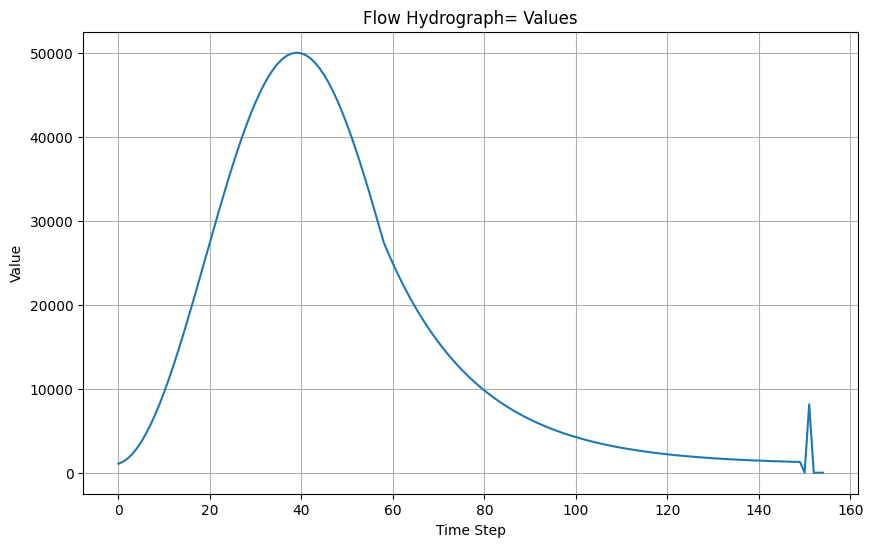

In [18]:
# Extract specific tables from the unsteady flow file
all_tables = RasUnsteady.extract_tables(new_unsteady_file)
print(f"Extracted {len(all_tables)} tables from the unsteady flow file.")

# Let's look at the available table names
print("\nAvailable tables:")
for table_name in all_tables.keys():
    print(f"  {table_name}")

# Select the first table for detailed analysis
if all_tables and len(all_tables) > 0:
    first_table_name = list(all_tables.keys())[0]
    first_table = all_tables[first_table_name]
    
    print(f"\nDetailed look at table '{first_table_name}':")
    print(f"  Number of values: {len(first_table)}")
    print(f"  Min value: {first_table['Value'].min()}")
    print(f"  Max value: {first_table['Value'].max()}")
    print(f"  Mean value: {first_table['Value'].mean():.2f}")
    print(f"  First 10 values: {first_table['Value'].head(10).tolist()}")
    
    # Create a visualization of the table values
    try:
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(10, 6))
        plt.plot(first_table['Value'].values)
        plt.title(f"{first_table_name} Values")
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"Could not create visualization: {e}")
else:
    print("No tables found in the unsteady flow file.")

## Step 7: Modifying Flow Tables

Now let's demonstrate how to modify a flow table and write it back to the unsteady flow file. For this example, we'll scale all the values in a table by a factor.

#### Scaling existing values down by a 0.75 scale factor

In [19]:
# First, identify tables in the unsteady flow file
tables = RasUnsteady.identify_tables(open(new_unsteady_file, 'r').readlines())
print(f"Identified {len(tables)} tables in the unsteady flow file.")

# Let's look at the first flow hydrograph table
flow_hydrograph_tables = [t for t in tables if t[0] == 'Flow Hydrograph=']
if flow_hydrograph_tables:
    table_name, start_line, end_line = flow_hydrograph_tables[0]
    print(f"\nSelected table: {table_name}")
    print(f"  Start line: {start_line}")
    print(f"  End line: {end_line}")
    
    # Parse the table
    lines = open(new_unsteady_file, 'r').readlines()
    table_df = RasUnsteady.parse_fixed_width_table(lines, start_line, end_line)
    print(f"\nOriginal table statistics:")
    print(f"  Number of values: {len(table_df)}")
    print(f"  Min value: {table_df['Value'].min()}")
    print(f"  Max value: {table_df['Value'].max()}")
    print(f"  First 5 values: {table_df['Value'].head(5).tolist()}")
    
    # Modify the table - let's scale all values by 75%
    scale_factor = 0.75
    table_df['Value'] = table_df['Value'] * scale_factor
    print(f"\nModified table statistics (scaled by {scale_factor}):")
    print(f"  Number of values: {len(table_df)}")
    print(f"  Min value: {table_df['Value'].min()}")
    print(f"  Max value: {table_df['Value'].max()}")
    print(f"  First 5 values: {table_df['Value'].head(5).tolist()}")
    
    # Write the modified table back to the file
    RasUnsteady.write_table_to_file(new_unsteady_file, table_name, table_df, start_line)
    print(f"\nUpdated table written back to the unsteady flow file.")
    
    # Re-read the table to verify changes
    lines = open(new_unsteady_file, 'r').readlines()
    updated_table_df = RasUnsteady.parse_fixed_width_table(lines, start_line, end_line)
    print(f"\nVerified updated table statistics:")
    print(f"  Number of values: {len(updated_table_df)}")
    print(f"  Min value: {updated_table_df['Value'].min()}")
    print(f"  Max value: {updated_table_df['Value'].max()}")
    print(f"  First 5 values: {updated_table_df['Value'].head(5).tolist()}")
else:
    print("No flow hydrograph tables found in the unsteady flow file.")

2025-12-15 12:24:29 - ras_commander.RasUnsteady - INFO - Successfully updated table 'Flow Hydrograph=' in C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.u01


Identified 3 tables in the unsteady flow file.

Selected table: Flow Hydrograph=
  Start line: 7
  End line: 35

Original table statistics:
  Number of values: 155
  Min value: 0.0
  Max value: 50000.0
  First 5 values: [1075.53, 1301.64, 1676.94, 2199.12, 2864.95]

Modified table statistics (scaled by 0.75):
  Number of values: 155
  Min value: 0.0
  Max value: 37500.0
  First 5 values: [806.6475, 976.23, 1257.705, 1649.34, 2148.7124999999996]

Updated table written back to the unsteady flow file.

Verified updated table statistics:
  Number of values: 159
  Min value: 0.0
  Max value: 37500.0
  First 5 values: [806.65, 976.23, 1257.7, 1649.34, 2148.71]


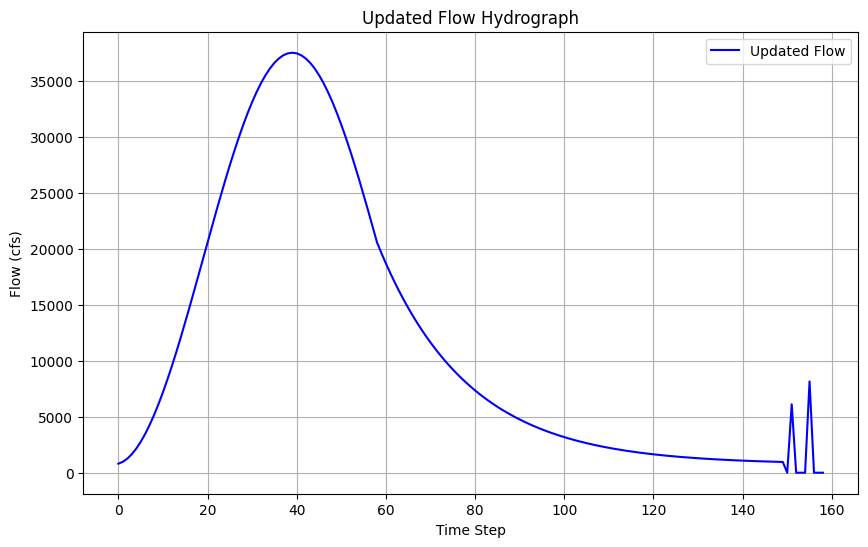


Updated flow hydrograph statistics:
  Number of values: 159
  Min flow: 0.0 cfs
  Max flow: 37500.0 cfs
  Mean flow: 11549.3 cfs


In [20]:
# Extract specific tables from the unsteady flow file
all_tables = RasUnsteady.extract_tables(new_unsteady_file)

# Get the updated flow hydrograph table
flow_hydrograph_tables = [t for t in all_tables.keys() if 'Flow Hydrograph=' in t]
if flow_hydrograph_tables:
    table_name = flow_hydrograph_tables[0]
    table_df = all_tables[table_name]
    
    # Create visualization of the updated flow values
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.plot(table_df['Value'].values, 'b-', label='Updated Flow')
    plt.title('Updated Flow Hydrograph')
    plt.xlabel('Time Step') 
    plt.ylabel('Flow (cfs)')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Print summary statistics
    print(f"\nUpdated flow hydrograph statistics:")
    print(f"  Number of values: {len(table_df)}")
    print(f"  Min flow: {table_df['Value'].min():.1f} cfs")
    print(f"  Max flow: {table_df['Value'].max():.1f} cfs")
    print(f"  Mean flow: {table_df['Value'].mean():.1f} cfs")
else:
    print("No flow hydrograph tables found in the unsteady flow file.")

In [21]:
# Execute Plan 01 to generate model results

RasCmdr.compute_plan("01")

2025-12-15 12:24:29 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek


2025-12-15 12:24:29 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-15 12:24:29 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.prj" "C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.p01"


2025-12-15 12:25:59 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 01


2025-12-15 12:25:59 - ras_commander.RasCmdr - INFO - Total run time for plan 01: 90.62 seconds


True

In [22]:
# Get cross section results timeseries as xarray dataset
xsec_results_xr_plan1 = HdfResultsXsec.get_xsec_timeseries("01")

2025-12-15 12:25:59 - ras_commander.hdf.HdfResultsXsec - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.p01.hdf


In [23]:
xsec_results_xr_plan1

<xarray.Dataset> Size: 587kB
Dimensions:                   (time: 150, cross_section: 178)
Coordinates:
  * time                      (time) datetime64[ns] 1kB 1999-02-18 ... 1999-0...
  * cross_section             (cross_section) <U42 30kB 'Bald Eagle       Loc...
    River                     (cross_section) <U10 7kB 'Bald Eagle' ... 'Bald...
    Reach                     (cross_section) <U7 5kB 'Loc Hav' ... 'Loc Hav'
    Station                   (cross_section) <U8 6kB '138154.4' ... '659.942'
    Name                      (cross_section) <U1 712B '' '' '' '' ... '' '' ''
    Maximum_Water_Surface     (cross_section) float32 712B 672.8 672.8 ... 561.4
    Maximum_Flow              (cross_section) float32 712B 5e+04 ... 2.543e+04
    Maximum_Channel_Velocity  (cross_section) float32 712B 11.81 8.031 ... 2.028
    Maximum_Velocity_Total    (cross_section) float32 712B 9.371 5.379 ... 1.632
    Maximum_Flow_Lateral      (cross_section) float32 712B 0.0 0.0 ... 0.0 0.0
Data variables:
    Water_Surface             (time, cross_section) float32 107kB 660.7 ... 5...
    Velocity_Total            (time, cross_section) float32 107kB 0.0 ... 1.227
    Velocity_Channel          (time, cross_section) float32 107kB 0.0 ... 1.286
    Flow_Lateral              (time, cross_section) float32 107kB 0.0 ... 0.0
    Flow                      (time, cross_section) float32 107kB 2e+03 ... 2...
Attributes:
    description:  Cross-section results extracted from HEC-RAS HDF file
    source_file:  C:\GH\ras-commander\examples\example_projects_03_unsteady_f...


Time Series Data for Cross Section: Bald Eagle       Loc Hav          136202.3

Water_Surface:
Plan 1:
[657.4173  656.7111  657.02997 657.44073 657.88824]

Velocity_Total:
Plan 1:
[0.        2.7810786 2.9612713 2.9395368 3.0228102]

Velocity_Channel:
Plan 1:
[0.        3.132834  3.4508243 3.7217746 4.083391 ]

Flow_Lateral:
Plan 1:
[0. 0. 0. 0. 0.]

Flow:
Plan 1:
[2000.     1273.8193 1607.1132 2109.992  2746.2964]


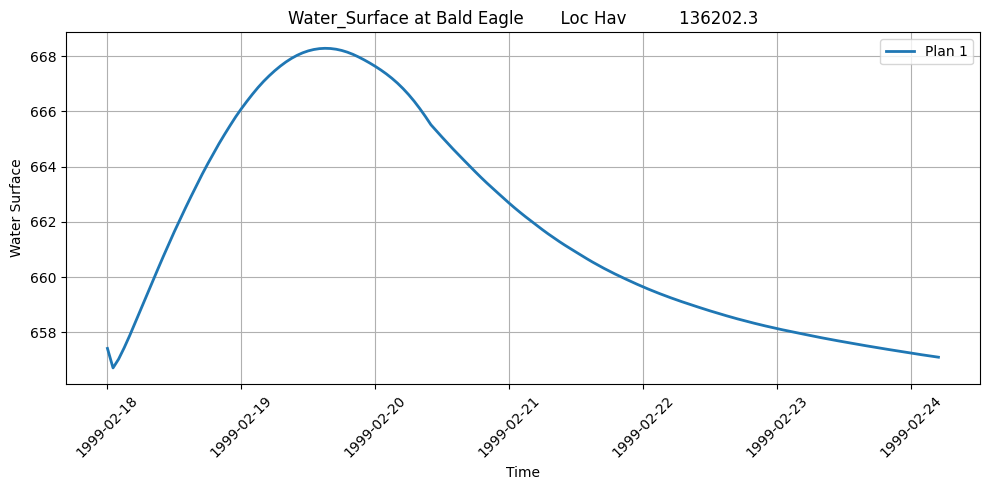

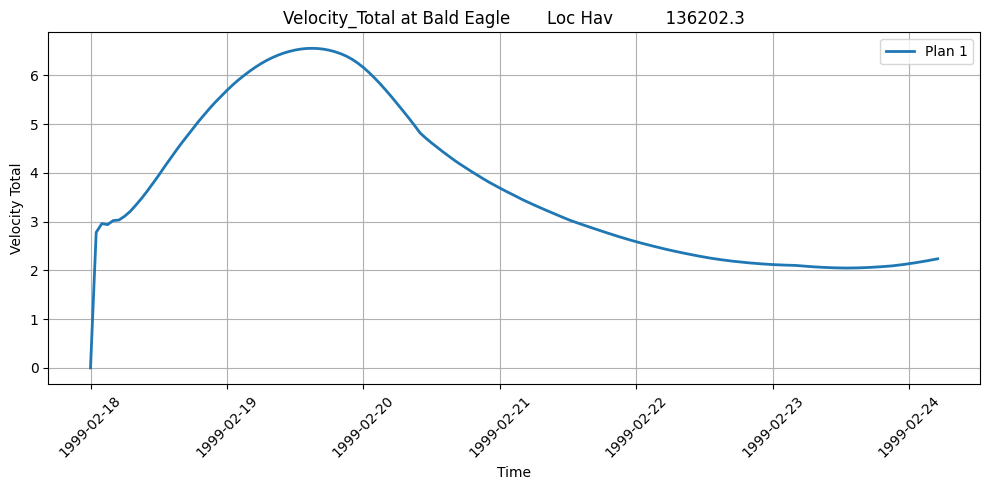

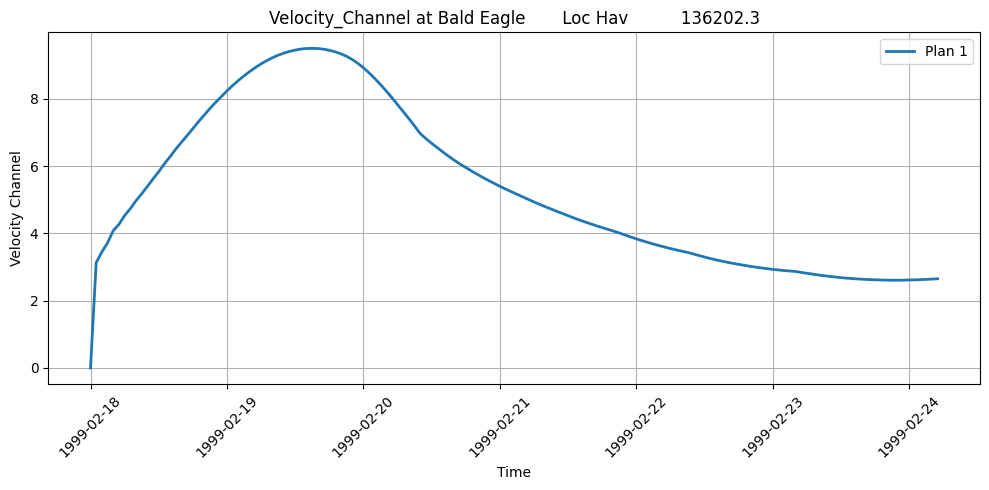

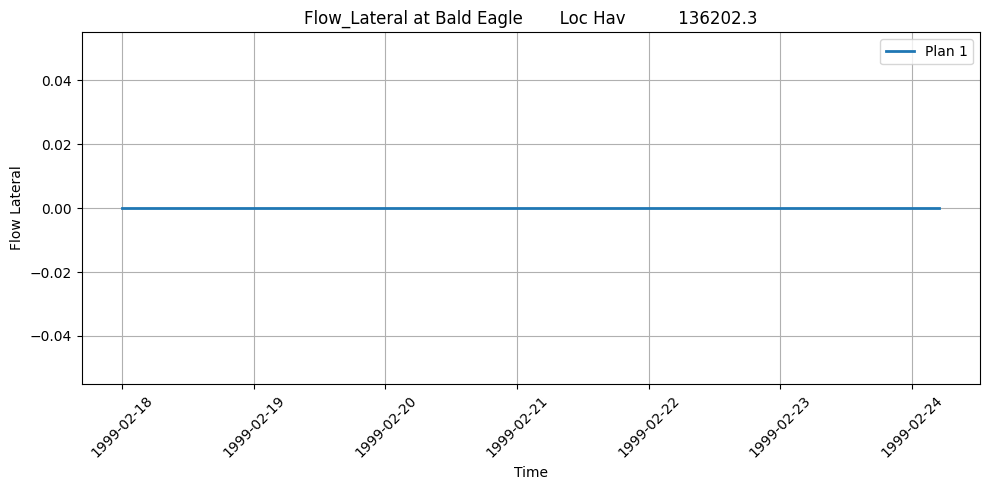

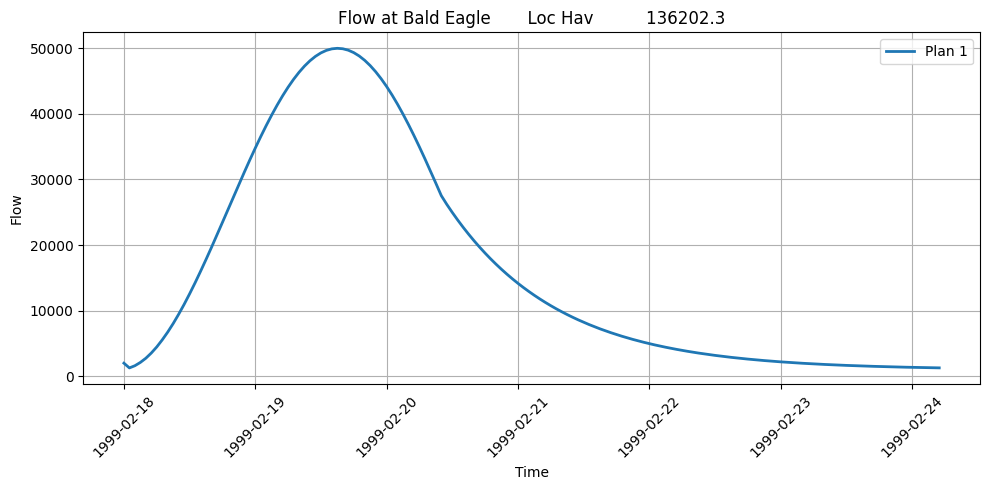

In [24]:
# Print time series for specific cross section
target_xs = "Bald Eagle       Loc Hav          136202.3"

print("\nTime Series Data for Cross Section:", target_xs)
for var in ['Water_Surface', 'Velocity_Total', 'Velocity_Channel', 'Flow_Lateral', 'Flow']:
    print(f"\n{var}:")
    print(f"Plan 1:")
    print(xsec_results_xr_plan1[var].sel(cross_section=target_xs).values[:5])  # Show first 5 values


# Create time series plots
if generate_plots:

    # Create a figure for each variable
    variables = ['Water_Surface', 'Velocity_Total', 'Velocity_Channel', 'Flow_Lateral', 'Flow']

    for var in variables:
        plt.figure(figsize=(10, 5))
        
        # Convert time values to datetime if needed
        time_values1 = pd.to_datetime(xsec_results_xr_plan1.time.values)
        values1 = xsec_results_xr_plan1[var].sel(cross_section=target_xs).values

        
        # Plot both plans
        plt.plot(time_values1, values1, '-', linewidth=2, label='Plan 1')
        
        plt.title(f'{var} at {target_xs}')
        plt.xlabel('Time')
        plt.ylabel(var.replace('_', ' '))
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        
        # Force display
        plt.draw()
        plt.pause(0.1)
        plt.show()


## Step 8: Applying the Updated Unsteady Flow to a New Plan

Now that we've modified an unsteady flow file, let's create a plan that uses it, and compute the results.

In [25]:
# Clone an existing plan
new_plan_number = RasPlan.clone_plan("01", new_plan_shortid="Modified Flow Test")
print(f"New plan created: {new_plan_number}")

2025-12-15 12:26:01 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.p01 to C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.p03


2025-12-15 12:26:01 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.p03


2025-12-15 12:26:01 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 03


2025-12-15 12:26:01 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.rasmap


New plan created: 03


In [26]:
new_plan_number

'03'

In [27]:
# Get the current plan title and shortid
current_title = RasPlan.get_plan_title(new_plan_number)
current_shortid = RasPlan.get_shortid(new_plan_number)

print(f"Current plan title: {current_title}")
print(f"Current plan shortid: {current_shortid}")

2025-12-15 12:26:01 - ras_commander.RasPlan - INFO - Retrieved Plan Title: Unsteady with Bridges and Dam


2025-12-15 12:26:01 - ras_commander.RasPlan - INFO - Retrieved Short Identifier: Modified Flow Test


Current plan title: Unsteady with Bridges and Dam
Current plan shortid: Modified Flow Test


In [28]:
# Update the title and shortid to append " clonedplan"
new_title = f"{current_title} 0.75 Flow Scale Factor"
new_shortid = f"{current_shortid} 0.75 FSF"

RasPlan.set_plan_title(new_plan_number, new_title)
RasPlan.set_shortid(new_plan_number, new_shortid)

print(f"\nUpdated plan title: {RasPlan.get_plan_title(new_plan_number)}")
print(f"Updated plan shortid: {RasPlan.get_shortid(new_plan_number)}")

2025-12-15 12:26:01 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.p03


2025-12-15 12:26:01 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: Unsteady with Bridges and Dam 0.75 Flow Scale Factor


2025-12-15 12:26:01 - ras_commander.RasPlan - WARNING - Short Identifier too long (24 char max). Truncating: Modified Flow Test 0.75 FSF


2025-12-15 12:26:01 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.p03


2025-12-15 12:26:01 - ras_commander.RasPlan - INFO - Updated Short Identifier in plan file to: Modified Flow Test 0.75 


2025-12-15 12:26:01 - ras_commander.RasPlan - INFO - Retrieved Plan Title: Unsteady with Bridges and Dam 0.75 Flow Scale Factor


2025-12-15 12:26:01 - ras_commander.RasPlan - INFO - Retrieved Short Identifier: Modified Flow Test 0.75



Updated plan title: Unsteady with Bridges and Dam 0.75 Flow Scale Factor
Updated plan shortid: Modified Flow Test 0.75


In [29]:
# Print new_unsteady_number again as a reminder of it's current value
new_unsteady_number

'01'

In [30]:
# Set the modified unsteady flow for the new plan
RasPlan.set_unsteady(new_plan_number, new_unsteady_number)
print(f"Set unsteady flow {new_unsteady_number} for plan {new_plan_number}")

Set unsteady flow 01 for plan 03


In [31]:
# Set the modified unsteady flow for the new plan
RasPlan.set_unsteady(new_plan_number, new_unsteady_number)
print(f"Set unsteady flow {new_unsteady_number} for plan {new_plan_number}")

Set unsteady flow 01 for plan 03


In [32]:
# Get the path to the new plan file
new_plan_path = RasPlan.get_plan_path(new_plan_number)

# Print contents of new plan file to confirm changes
# Read and display the contents of the plan file
with open(new_plan_path, 'r') as f:
    plan_contents = f.read()
print(f"Contents of plan file {new_plan_number}:")
print(plan_contents)


Contents of plan file 03:
Plan Title=Unsteady with Bridges and Dam 0.75 Flow Scale Factor
Program Version=5.00
Short Identifier=Modified Flow Test 0.75 
Simulation Date=18FEB1999,0000,24FEB1999,0500
Geom File=g01
Flow File=u01
Subcritical Flow
K Sum by GR= 0 
Std Step Tol= 0.01 
Critical Tol= 0.01 
Num of Std Step Trials= 20 
Max Error Tol= 0.3 
Flow Tol Ratio= 0.001 
Split Flow NTrial= 30 
Split Flow Tol= 0.02 
Split Flow Ratio= 0.02 
Log Output Level= 0 
Friction Slope Method= 2 
Unsteady Friction Slope Method= 2 
Unsteady Bridges Friction Slope Method= 1 
Parabolic Critical Depth
Global Vel Dist= 0 , 0 , 0 
Global Log Level= 0 
CheckData=True
Encroach Param=-1 ,0,0, 0 
Computation Interval=2MIN
Output Interval=1HOUR
Instantaneous Interval=2HOUR
Mapping Interval=1HOUR
Run HTab= 1 
Run UNet= 1 
Run Sediment= 0 
Run PostProcess= 1 
Run WQNet= 0 
Run RASMapper= 0 
UNET Theta= 1 
UNET Theta Warmup= 1 
UNET ZTol= 0.01 
UNET ZSATol= 0.1 
UNET QTol=
UNET MxIter= 20 
UNET Max Iter WO Improve

In [33]:
# Update the plan description
new_description = "Test plan using modified unsteady flow\nFlow scaled to 75% of original\nWith restart file enabled"
RasPlan.update_plan_description(new_plan_number, new_description)
print(f"Updated plan description for plan {new_plan_number}")

# Set computation options
RasPlan.set_num_cores(new_plan_number, 2)

# Consider any other changes you want to make at this step, such as computation intervals etc: 
# RasPlan.update_plan_intervals(
#    new_plan_number,
#    computation_interval="1MIN",
#    output_interval="15MIN",
#    mapping_interval="1HOUR"
#)  

2025-12-15 12:26:01 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.p03


2025-12-15 12:26:01 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.p03


Updated plan description for plan 03


In [34]:
# Compute the plan
print(f"\nComputing plan {new_plan_number} with modified unsteady flow...")
success = RasCmdr.compute_plan(new_plan_number)

2025-12-15 12:26:01 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek


2025-12-15 12:26:01 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-15 12:26:01 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.prj" "C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.p03"



Computing plan 03 with modified unsteady flow...


2025-12-15 12:26:15 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 03


2025-12-15 12:26:15 - ras_commander.RasCmdr - INFO - Total run time for plan 03: 14.63 seconds


In [35]:
if success:
    print(f"Plan {new_plan_number} computed successfully")
    
    # Check the results path
    results_path = RasPlan.get_results_path(new_plan_number)
    if results_path:
        print(f"Results available at: {results_path}")
        
        # If it exists, get its size
        results_file = Path(results_path)
        if results_file.exists():
            size_mb = results_file.stat().st_size / (1024 * 1024)
            print(f"Results file size: {size_mb:.2f} MB")
    else:
        print("No results found.")
else:
    print(f"Failed to compute plan {new_plan_number}")

Plan 03 computed successfully
Results available at: C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.p03.hdf
Results file size: 7.37 MB


In [36]:
# Show updated plan_df dataframe, which should show the HDF results files
ras.plan_df

,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,Run UNet,Run Sediment,Run PostProcess,Run WQNet,UNET Use Existing IB Tables,UNET D1 Cores,UNET D2 Cores,PS Cores,DSS File,Friction Slope Method,description,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,01,02,01,Unsteady with Bridges and Dam,5.00,UnsteadyFlow,"18FEB1999,0000,24FEB1999,0500",2MIN,1HOUR,1,1,0,1,0,-1,0.0,0.0,None,dss,2,NaN,C:\GH\ras-commander\examples\example_projects_...,01,C:\GH\ras-commander\examples\example_projects_...,02,C:\GH\ras-commander\examples\example_projects_...,C:\GH\ras-commander\examples\example_projects_...
1,02,None,01,Steady Flow Run,NaN,SteadyRun,"02/18/1999,0000,02/24/1999,0500",2MIN,NaN,1,1,NaN,1,NaN,NaN,NaN,NaN,None,dss,1,NaN,None,01,C:\GH\ras-commander\examples\example_projects_...,02,C:\GH\ras-commander\examples\example_projects_...,C:\GH\ras-commander\examples\example_projects_...
2,03,01,01,Unsteady with Bridges and Dam 0.75 Flow Scale ...,5.00,Modified Flow Test 0.75,"18FEB1999,0000,24FEB1999,0500",2MIN,1HOUR,1,1,0,1,0,-1,2.0,2.0,None,dss,2,Test plan using modified unsteady flow\nFlow s...,C:\GH\ras-commander\examples\example_projects_...,01,C:\GH\ras-commander\examples\example_projects_...,01,C:\GH\ras-commander\examples\example_projects_...,C:\GH\ras-commander\examples\example_projects_...


In [37]:
ras.unsteady_df

,unsteady_number,full_path,Flow Title,Program Version,Use Restart,Precipitation Mode,Wind Mode,Met BC=Precipitation|Mode,Met BC=Evapotranspiration|Mode,Met BC=Precipitation|Expanded View,Met BC=Precipitation|Constant Units,Met BC=Precipitation|Gridded Source
0,02,C:\GH\ras-commander\examples\example_projects_...,Flow Hydrograph 2,6.30,0,Disable,No Wind Forces,None,None,0,mm/hr,DSS
1,01,C:\GH\ras-commander\examples\example_projects_...,Modified Flow Scenario,6.30,0,Disable,No Wind Forces,None,None,0,mm/hr,DSS


## Get results for Plan 03 and Compare with Plan 01's results for the specified Cross Section
target_xs = "Bald Eagle       Loc Hav          136202.3"

In [38]:
# Get cross section results timeseries as xarray dataset
xsec_results_xr_plan2 = HdfResultsXsec.get_xsec_timeseries("03")

2025-12-15 12:26:15 - ras_commander.hdf.HdfResultsXsec - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects_03_unsteady_flow_operations\Balde Eagle Creek\BaldEagle.p03.hdf


In [39]:
xsec_results_xr_plan2

<xarray.Dataset> Size: 587kB
Dimensions:                   (time: 150, cross_section: 178)
Coordinates:
  * time                      (time) datetime64[ns] 1kB 1999-02-18 ... 1999-0...
  * cross_section             (cross_section) <U42 30kB 'Bald Eagle       Loc...
    River                     (cross_section) <U10 7kB 'Bald Eagle' ... 'Bald...
    Reach                     (cross_section) <U7 5kB 'Loc Hav' ... 'Loc Hav'
    Station                   (cross_section) <U8 6kB '138154.4' ... '659.942'
    Name                      (cross_section) <U1 712B '' '' '' '' ... '' '' ''
    Maximum_Water_Surface     (cross_section) float32 712B 670.9 670.8 ... 548.1
    Maximum_Flow              (cross_section) float32 712B 3.75e+04 ... 9.318...
    Maximum_Channel_Velocity  (cross_section) float32 712B 10.27 7.146 ... 1.532
    Maximum_Velocity_Total    (cross_section) float32 712B 8.222 4.746 ... 1.32
    Maximum_Flow_Lateral      (cross_section) float32 712B 0.0 0.0 ... 0.0 0.0
Data variables:
    Water_Surface             (time, cross_section) float32 107kB 660.7 ... 5...
    Velocity_Total            (time, cross_section) float32 107kB 0.0 ... 1.231
    Velocity_Channel          (time, cross_section) float32 107kB 0.0 ... 1.287
    Flow_Lateral              (time, cross_section) float32 107kB 0.0 ... 0.0
    Flow                      (time, cross_section) float32 107kB 2e+03 ... 2...
Attributes:
    description:  Cross-section results extracted from HEC-RAS HDF file
    source_file:  C:\GH\ras-commander\examples\example_projects_03_unsteady_f...


Time Series Data for Cross Section: Bald Eagle       Loc Hav          136202.3

Water_Surface:
Plan 1:
[657.4173  656.7111  657.02997 657.44073 657.88824]
Plan 2:
[657.4173  656.3783  656.6591  657.0057  657.40375]

Velocity_Total:
Plan 1:
[0.        2.7810786 2.9612713 2.9395368 3.0228102]
Plan 2:
[0.        2.496069  2.740619  2.962329  2.9375973]

Velocity_Channel:
Plan 1:
[0.        3.132834  3.4508243 3.7217746 4.083391 ]
Plan 2:
[0.        2.7249618 3.0739226 3.431731  3.6956408]

Flow_Lateral:
Plan 1:
[0. 0. 0. 0. 0.]
Plan 2:
[0. 0. 0. 0. 0.]

Flow:
Plan 1:
[2000.     1273.8193 1607.1132 2109.992  2746.2964]
Plan 2:
[2000.      953.5375 1222.7786 1576.9309 2062.2295]


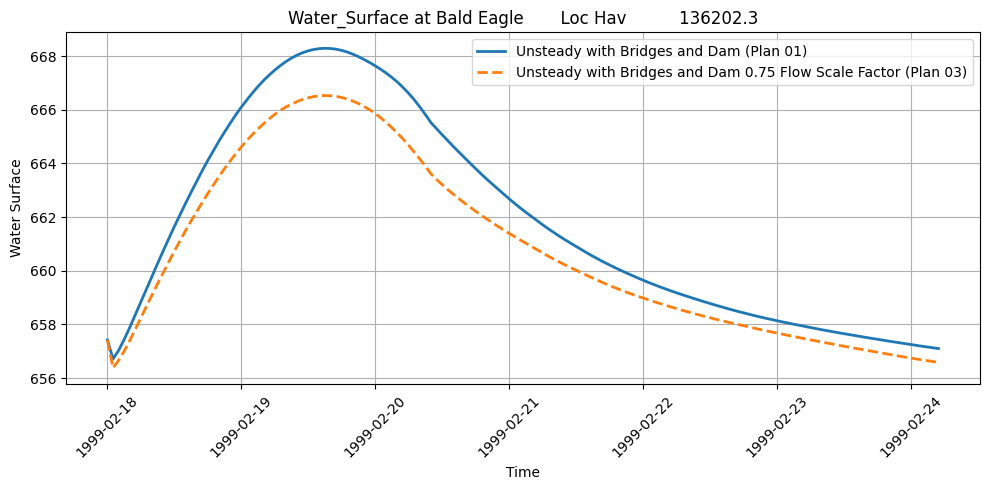

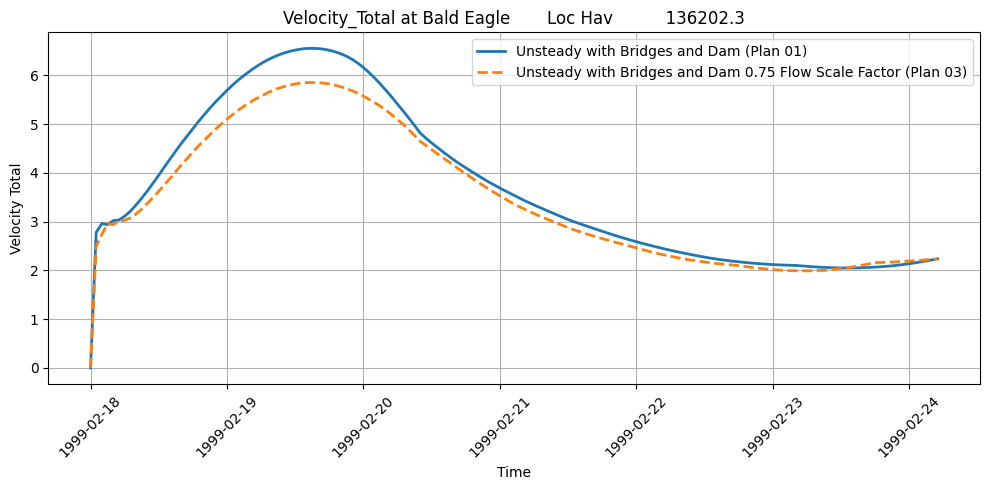

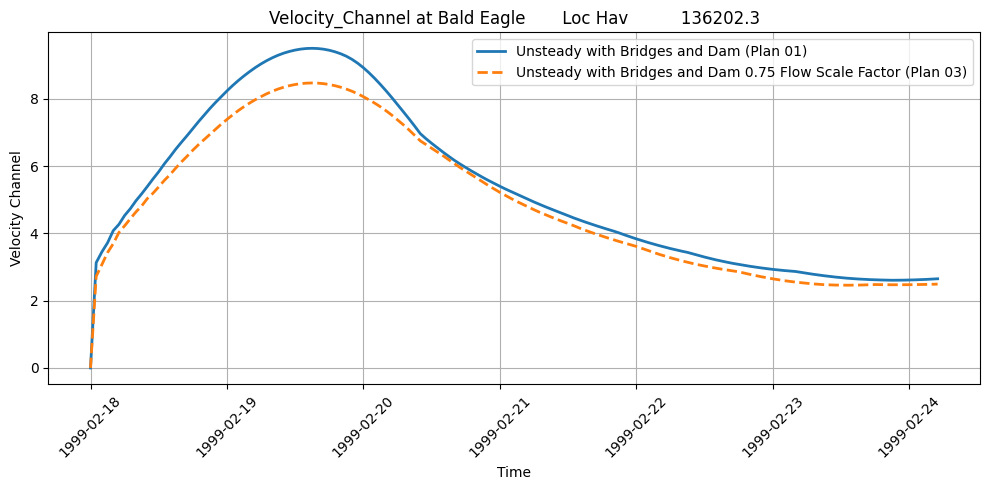

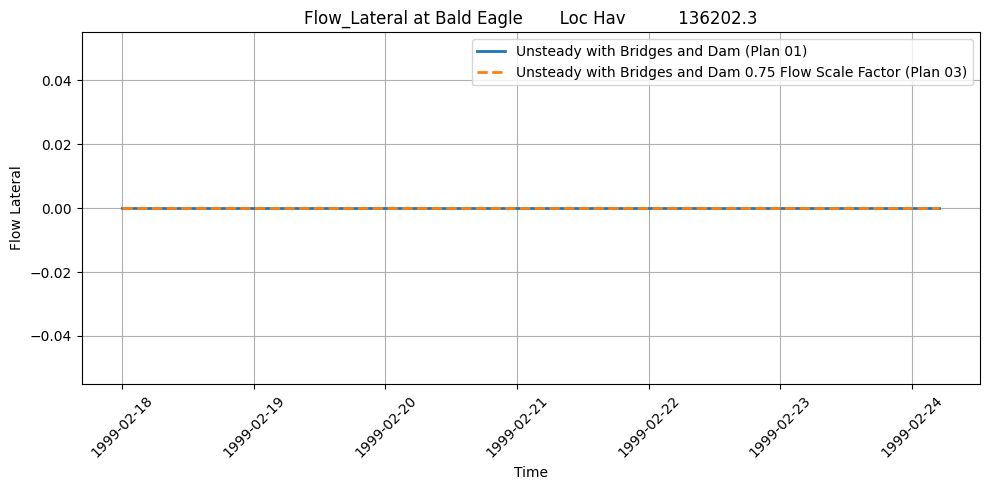

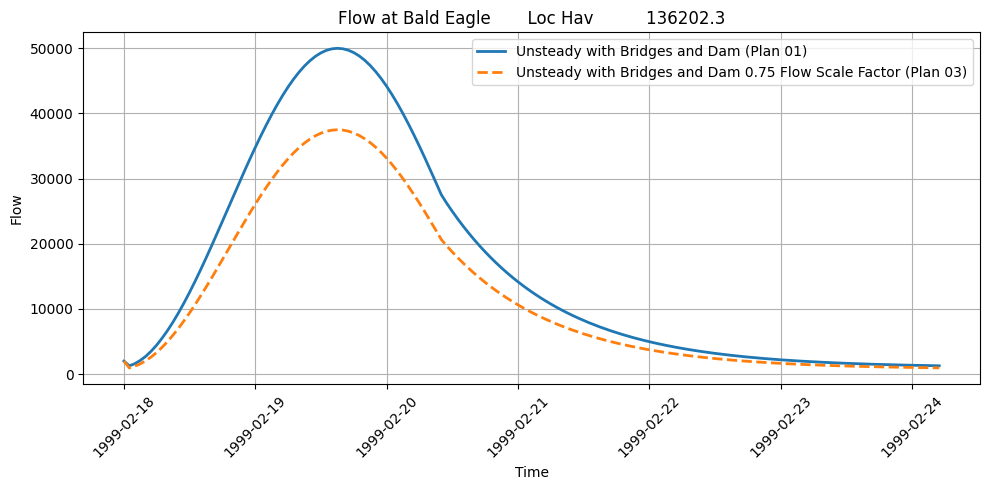

In [40]:
# Print time series for specific cross section
target_xs = "Bald Eagle       Loc Hav          136202.3"

print("\nTime Series Data for Cross Section:", target_xs)
for var in ['Water_Surface', 'Velocity_Total', 'Velocity_Channel', 'Flow_Lateral', 'Flow']:
    print(f"\n{var}:")
    print(f"Plan 1:")
    print(xsec_results_xr_plan1[var].sel(cross_section=target_xs).values[:5])  # Show first 5 values
    print(f"Plan 2:")
    print(xsec_results_xr_plan2[var].sel(cross_section=target_xs).values[:5])  # Show first 5 values

# Create time series plots
if generate_plots:

    # Create a figure for each variable
    variables = ['Water_Surface', 'Velocity_Total', 'Velocity_Channel', 'Flow_Lateral', 'Flow']

    for var in variables:
        plt.figure(figsize=(10, 5))
        
        # Convert time values to datetime if needed
        time_values1 = pd.to_datetime(xsec_results_xr_plan1.time.values)
        time_values2 = pd.to_datetime(xsec_results_xr_plan2.time.values)
        values1 = xsec_results_xr_plan1[var].sel(cross_section=target_xs).values
        values2 = xsec_results_xr_plan2[var].sel(cross_section=target_xs).values
        
        # Get plan titles from plan_df
        plan1_title = ras.plan_df.loc[ras.plan_df['plan_number'] == '01', 'Plan Title'].iloc[0]
        plan2_title = ras.plan_df.loc[ras.plan_df['plan_number'] == '03', 'Plan Title'].iloc[0]
        
        # Plot both plans with titles
        plt.plot(time_values1, values1, '-', linewidth=2, label=f'{plan1_title} (Plan 01)')
        plt.plot(time_values2, values2, '--', linewidth=2, label=f'{plan2_title} (Plan 03)')
        
        plt.title(f'{var} at {target_xs}')
        plt.xlabel('Time')
        plt.ylabel(var.replace('_', ' '))
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        
        # Force display
        plt.draw()
        plt.pause(0.1)
        plt.show()


## Summary of Unsteady Flow Operations

In this notebook, we've covered the following unsteady flow operations using RAS Commander:

1. **Project Initialization**: We initialized a HEC-RAS project to work with
2. **Boundary Extraction**: We extracted boundary conditions and tables from unsteady flow files
3. **Boundary Analysis**: We inspected and understood boundary condition structures
4. **Flow Title Updates**: We modified the title of an unsteady flow file
5. **Restart Settings**: We configured restart file settings for continuing simulations
6. **Table Extraction**: We extracted flow tables for analysis
7. **Table Modification**: We modified a flow table and wrote it back to the file
8. **Application**: We created a plan using our modified unsteady flow and computed results

### Key Classes and Functions Used

- `RasUnsteady.extract_boundary_and_tables()`: Extract boundary conditions and tables
- `RasUnsteady.print_boundaries_and_tables()`: Display formatted boundary information
- `RasUnsteady.update_flow_title()`: Modify the flow title
- `RasUnsteady.update_restart_settings()`: Configure restart options
- `RasUnsteady.extract_tables()`: Extract tables from unsteady flow files
- `RasUnsteady.identify_tables()`: Identify table locations in file
- `RasUnsteady.parse_fixed_width_table()`: Parse fixed-width tables
- `RasUnsteady.write_table_to_file()`: Write modified tables back to file

### Next Steps

To further explore unsteady flow operations with RAS Commander, consider:

1. **Advanced Flow Modifications**: Create scripts that systematically modify flow hydrographs
2. **Sensitivity Analysis**: Create variations of unsteady flows to assess model sensitivity
3. **Batch Processing**: Process multiple unsteady flow files for scenario analysis
4. **Custom Boundary Conditions**: Create unsteady flows from external data sources
5. **Results Analysis**: Compare results from different unsteady flow scenarios

These advanced topics can be explored by building on the foundation established in this notebook.